In [1]:
!python --version

Python 3.9.25


In [2]:
# sanity check
# import numpy as np
# import tensorflow as tf
# import tensorflow_privacy

# print("NumPy:", np.__version__)
# print("TensorFlow:", tf.__version__)
# print("TF-Privacy:", tensorflow_privacy.__version__)




In [3]:
# =========================
# Standard Library
# =========================
import os
import random
import time
import warnings

# =========================
# Third-Party: Numerical / Data
# =========================
import numpy as np
import pandas as pd

# =========================
# Third-Party: Visualization
# =========================
import matplotlib.pyplot as plt
import seaborn as sns

# =========================
# Third-Party: sklearn
# =========================
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler, StandardScaler
from sklearn.utils import resample, shuffle
from sklearn.metrics import (
    accuracy_score,
    average_precision_score,
    auc,
    confusion_matrix,
    f1_score,
    precision_recall_curve,
    precision_score,
    recall_score,
)

# =========================
# Third-Party: Imbalanced-Learn
# =========================
from imblearn.over_sampling import RandomOverSampler

# =========================
# Third-Party: TensorFlow & Privacy
# =========================
import tensorflow as tf
from tensorflow import keras  # ---included
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    LSTM,
    Dense,
    Dropout,
    Flatten,
    Conv2D,
    MaxPooling2D,
)
from tensorflow.keras.optimizers import Adam, SGD
from tensorflow.keras.metrics import (
    TruePositives,
    TrueNegatives,
    FalsePositives,
    FalseNegatives,
)

import tensorflow_privacy
from tensorflow_privacy.privacy.analysis import compute_dp_sgd_privacy

# =========================
# Third-Party: Genetic Algorithm (DEAP)
# =========================
from deap import base, creator, tools

# =========================
# Warnings
# =========================
warnings.filterwarnings("ignore", category=UserWarning)


In [4]:
data  = pd.read_csv(r"C:\Users\dmachooka\Downloads\dmac\data.csv")

In [5]:
data.head(2)

,timestamp,src_ip,dst_ip,protocol,ttl,ip_len,ip_flag_df,ip_flag_mf,ip_flag_rb,src_port,...,tcp_flag_ns,tcp_flag_cwr,tcp_flag_ecn,tcp_flag_urg,tcp_flag_ack,tcp_flag_push,tcp_flag_reset,tcp_flag_syn,tcp_flag_fin,is_attack
0,"02/14/2020, 11:01:47:599181",1,18,12,26,118,1,0,0,14816,...,0,0,0,0,2,2,0,0,2,0
1,"02/14/2020, 10:53:58:393457",5,18,12,26,118,1,0,0,27432,...,0,0,0,0,2,2,0,0,2,0


In [6]:
data.isna().sum()

timestamp         0
src_ip            0
dst_ip            0
protocol          0
ttl               0
ip_len            0
ip_flag_df        0
ip_flag_mf        0
ip_flag_rb        0
src_port          0
dst_port          0
tcp_flag_res      0
tcp_flag_ns       0
tcp_flag_cwr      0
tcp_flag_ecn      0
tcp_flag_urg      0
tcp_flag_ack      0
tcp_flag_push     0
tcp_flag_reset    0
tcp_flag_syn      0
tcp_flag_fin      0
is_attack         0
dtype: int64

In [7]:
data.columns

Index(['timestamp', 'src_ip', 'dst_ip', 'protocol', 'ttl', 'ip_len',
       'ip_flag_df', 'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port',
       'tcp_flag_res', 'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn',
       'tcp_flag_urg', 'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset',
       'tcp_flag_syn', 'tcp_flag_fin', 'is_attack'],
      dtype='object')

In [8]:
try:
    data = data.drop('timestamp', axis=1)
except KeyError:
    pass

In [9]:
data.columns

Index(['src_ip', 'dst_ip', 'protocol', 'ttl', 'ip_len', 'ip_flag_df',
       'ip_flag_mf', 'ip_flag_rb', 'src_port', 'dst_port', 'tcp_flag_res',
       'tcp_flag_ns', 'tcp_flag_cwr', 'tcp_flag_ecn', 'tcp_flag_urg',
       'tcp_flag_ack', 'tcp_flag_push', 'tcp_flag_reset', 'tcp_flag_syn',
       'tcp_flag_fin', 'is_attack'],
      dtype='object')

In [10]:
target_column = 'is_attack'
categorical_columns = [col for col in data.columns if col not in [target_column]]

In [11]:
X = data.drop(target_column, axis=1)
y = data[target_column]

X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.25, random_state=42)

X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.4, random_state=42)



# Standard Scaling
scaler = StandardScaler()

#Perfom feature scaling for the training set
X_train_scaled = X_train.copy()
X_train_scaled[categorical_columns] = scaler.fit_transform(X_train[categorical_columns])

#Perfom feature scaling for the training set
X_valid_scaled = X_valid.copy()
X_valid_scaled[categorical_columns] = scaler.transform(X_valid[categorical_columns])

#Perfom feature scaling for the test set
X_test_scaled = X_test.copy()
X_test_scaled[categorical_columns] = scaler.transform(X_test[categorical_columns])

# Reshape data for LSTM

#I now convert the scaled training set into a NP Arrays and then reshape it

#I reshaped it to be compatible with the expected inputs by LSTM model
X_train_numpy = X_train_scaled[categorical_columns].to_numpy()
X_train_lstm = X_train_numpy.reshape(X_train_numpy.shape[0], 1, X_train_numpy.shape[1])

In [12]:
# Function to plot loss curves
def plot_loss(history1, history2=None):
    plt.figure(figsize=(12, 4))

    # Plot training & validation loss values for the first model
    plt.subplot(1, 2, 1)
    plt.plot(history1.history['loss'])
    plt.plot(history1.history['val_loss'])
    plt.title('Model loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(['Train', 'Validation'], loc='upper right')

    # Plot training & validation accuracy values for the first model
    plt.subplot(1, 2, 2)
    plt.plot(history1.history['accuracy'])
    plt.plot(history1.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(['Train', 'Validation'], loc='lower right')

    if history2 is not None:
        # Plot training & validation loss values for the second model
        plt.subplot(1, 2, 1)
        plt.plot(history2.history['loss'], linestyle='dashed')
        plt.plot(history2.history['val_loss'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='upper right')

        # Plot training & validation accuracy values for the second model
        plt.subplot(1, 2, 2)
        plt.plot(history2.history['accuracy'], linestyle='dashed')
        plt.plot(history2.history['val_accuracy'], linestyle='dashed')
        plt.legend(['Train', 'Validation', 'Train Privacy', 'Validation Privacy'], loc='lower right')

    plt.tight_layout()
    plt.show()

## Privacy GA

In [42]:
# --- Define parameter search space --- full traininning 7-24 days
# LSTM_UNITS = [16, 32, 64, 128, 256]
# DENSE_UNITS = [16, 32, 64, 128, 256]
ACTIVATIONS = ['gelu', 'swish', 'silu', 'relu']
OPTIMIZERS = ['sgd', 'adam']
LOSSES = ['binary_crossentropy']
LEARNING_RATES = [0.001, 0.0001]
BATCH_SIZES = [64, 128, 256]
EPOCHS = [20, 30, 50, 100]
# MAX_LSTM_LAYERS = 3
# MAX_DENSE_LAYERS = 4
noise_multiplier=1.3
gene_alg = True
LAYERS = [4, 6, 8]
UNITS = [16,32,64, 128, 256]

In [43]:
# shorter training 7-14 days
# gene_alg = True
# ACTIVATIONS = ['gelu', 'swish', 'silu', 'relu']
# OPTIMIZERS = ['sgd', 'adam']
# LAYERS = [4, 6, 8]
# LOSSES = ['binary_crossentropy']
# LEARNING_RATES = [0.001, 0.0001]
# BATCH_SIZES = [128, 256]
# EPOCHS_CHOICES = [23, 30, 50, 100]
# UNITS = [64, 128, 256]

In [44]:
def evaluate_nn(hyperparams):
    units_1 = hyperparams['units_1']
    dropout_rates = hyperparams['dropouts']
    learning_rate = hyperparams['learning_rate']
    optimizer_choice = hyperparams['optimizer']

    mlp_model_privacy = Sequential()
    mlp_model_privacy.add(Dense(units=units_1, activation='relu', input_shape=(len(categorical_columns),)))
    mlp_model_privacy.add(Dropout(rate=dropout_rates[0]))

    for i in range(1, len(dropout_rates)):
        mlp_model_privacy.add(Dense(units=units_1, activation='relu'))
        mlp_model_privacy.add(Dropout(rate=dropout_rates[i]))

    mlp_model_privacy.add(Dense(2, activation='sigmoid'))

    # Set optimizer
    if optimizer_choice == 'adam':
        optimizer = Adam(learning_rate=learning_rate)
    else:
        optimizer = SGD(learning_rate=learning_rate)

    # Differential privacy parameters
    batch_size = 16
    l2_norm_clip = 1.0
    noise_multiplier = 1.3
    num_microbatches = 1

    # Create a DP optimizer
    dp_optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
        l2_norm_clip=l2_norm_clip,
        noise_multiplier=noise_multiplier,
        num_microbatches=num_microbatches,
        learning_rate=learning_rate
    )

    mlp_model_privacy.compile(optimizer=dp_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    # Perform 5-fold cross-validation
    kfold = StratifiedKFold(n_splits=2, shuffle=True, random_state=42)
    cv_results = []

    for train_index, test_index in kfold.split(X_train_scaled[categorical_columns], y_train):
        X_train_fold, X_val_fold = X_train_scaled[categorical_columns].iloc[train_index], X_train_scaled[categorical_columns].iloc[test_index]
        y_train_fold, y_val_fold = y_train.iloc[train_index], y_train.iloc[test_index]

        # Reshape labels for binary classification
        y_train_fold2 = tf.keras.utils.to_categorical(y_train_fold, num_classes=2)
        y_val_fold2 = tf.keras.utils.to_categorical(y_val_fold, num_classes=2)

        # Train the model on the current fold
        mlp_model_privacy.fit(X_train_fold, y_train_fold2, epochs=30, batch_size=batch_size // num_microbatches, verbose=0)
        # _, val_accuracy = model.evaluate(X_val_fold, y_val_fold, verbose=0)
        # cv_results.append(val_accuracy)
        # Predict class labels for F1
        y_pred_proba = mlp_model_privacy.predict(X_val_fold, verbose=0)
        y_pred = np.argmax(y_pred_proba, axis=1)   # convert softmax → class

        # convert one-hot val to labels
        # y_true_labels = np.argmax(y_val_fold2, axis=1)
        # f1 = f1_score(y_true_labels, y_pred, average="binary")  # or "macro" for multi-class


        y_true_labels = np.argmax(y_val_fold2, axis=1)
        y_pred_labels = np.argmax(y_pred_proba, axis=1)
        f1 = f1_score(y_true_labels, y_pred_labels, average="binary")  # or "macro" if >2 classes

        
        # Compute F1
        # f1 = f1_score(y_val_fold2, y_pred, average="macro")  # or "macro", "weighted"
        cv_results.append(f1)

    # Extract trainable variables from the model
    trainable_variables = mlp_model_privacy.trainable_variables

    # Compute privacy budget
    privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
        number_of_examples=len(X_train_scaled),
        batch_size=batch_size,
        noise_multiplier=1.3,
        num_epochs=30,
        delta=1e-5
    )

    epsilon = None

    # Case A: report is an object with epsilon attr
    if hasattr(privacy_report, "epsilon"):
        epsilon = privacy_report.epsilon

    # Case B: report is a tuple (epsilon, something)
    elif isinstance(privacy_report, tuple) and len(privacy_report) >= 1 and isinstance(privacy_report[0], (float, int)):
        epsilon = privacy_report[0]

    # Case C: report is a string
    elif isinstance(privacy_report, str):
        import re
        match = re.search(r"epsilon[^0-9]*([0-9.]+)", privacy_report.lower())
        if match:
            epsilon = float(match.group(1))

    score = np.mean(cv_results) - epsilon # GA maximizes score by default

    return score,

In [45]:
def custom_crossover(ind1, ind2):
    """Two-point crossover"""
    keys = list(ind1.keys())
    cx1, cx2 = sorted([random.randint(1, len(keys)-1) for _ in range(2)])
    for i in range(cx1, cx2):
        key = keys[i]
        ind1[key], ind2[key] = ind2[key], ind1[key]
    return ind1, ind2
    
def custom_mutation(ind):
    """Random mutation of one hyperparameter"""
    param = random.choice(list(ind.keys()))
    if param == 'units':
        n_layers = len(ind['units'])
        ind['units'] = [random.choice(UNITS) for _ in range(n_layers)]
    elif param == 'dropouts':
        ind['dropouts'] = [random.uniform(0.1, 0.5) for _ in range(len(ind['dropouts']))]
    elif param == 'activation':
        ind['activation'] = random.choice(ACTIVATIONS)
    elif param == 'optimizer':
        ind['optimizer'] = random.choice(OPTIMIZERS)
    elif param == 'loss':
        ind['loss'] = random.choice(LOSSES)
    elif param == 'learning_rate':
        ind['learning_rate'] = random.choice(LEARNING_RATES)
    elif param == 'batch_size':
        ind['batch_size'] = random.choice(BATCH_SIZES)
    elif param == 'epochs':
        ind['epochs'] = random.choice(EPOCHS)
    return ind,
    

In [46]:
def create_hyperparameter_set():
    return {
        'units_1': random.choice([64, 128, 256]),
        'dropouts': [random.uniform(0.1, 0.5) for _ in range(5)],
        'learning_rate': random.uniform(0.0001, 0.01),
        'optimizer': random.choice(['adam', 'sgd']),
        'batch_size': random.choice(BATCH_SIZES),                     # <-- ADDED
        'epochs': random.choice(EPOCHS_CHOICES),
    }

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", dict, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("individual", tools.initIterate, creator.Individual, create_hyperparameter_set)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

toolbox.register("mate", custom_crossover)
# toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutUniformInt, low=64, up=256, indpb=0.2)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate_nn)
toolbox.register("batch_size", random.choice, BATCH_SIZES)

C:\Users\dmachooka\AppData\Local\anaconda3\envs\tprivacy\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'FitnessMax' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
C:\Users\dmachooka\AppData\Local\anaconda3\envs\tprivacy\lib\site-packages\deap\creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [47]:
def genetic_algorithm():
    pop = toolbox.population(n=10)
    ngen = 5  # Number of generations
    cxpb, mutpb = 0.5, 0.2  # Crossover and mutation probabilities

    for gen in range(ngen):
        print(f"-- Generation {gen} --")

        # Evaluate all individuals
        fitnesses = list(map(toolbox.evaluate, pop))
        for ind, fit in zip(pop, fitnesses):
            ind.fitness.values = fit

        # Select individuals for the next generation
        offspring = toolbox.select(pop, len(pop))
        offspring = list(map(toolbox.clone, offspring))

        # Apply crossover and mutation on the offspring
        for child1, child2 in zip(offspring[::2], offspring[1::2]):
            if random.random() < cxpb:
                toolbox.mate(child1, child2)
                del child1.fitness.values
                del child2.fitness.values

        for mutant in offspring:
            if random.random() < mutpb:
                toolbox.mutate(mutant)
                del mutant.fitness.values

        # Evaluate the individuals with an invalid fitness
        invalid_ind = [ind for ind in offspring if not ind.fitness.valid]
        fitnesses = map(toolbox.evaluate, invalid_ind)
        for ind, fit in zip(invalid_ind, fitnesses):
            ind.fitness.values = fit

        pop[:] = offspring

    # Return the best individual
    top_individual = tools.selBest(pop, 1)[0]
    return top_individual

In [48]:
best_hyperparameters = genetic_algorithm()
print("Best Hyperparameters:", best_hyperparameters)

-- Generation 0 --
-- Generation 1 --
-- Generation 2 --
-- Generation 3 --
-- Generation 4 --
Best Hyperparameters: {'units_1': 128, 'dropouts': [0.15824528118702608, 0.24447440791838423, 0.19627686447981813, 0.11066548924064744, 0.23541216741831816], 'learning_rate': 0.0001572046606171887, 'optimizer': 'adam', 'batch_size': 256, 'epochs': 50, 4: 104}


In [ ]:
# full sample'units_1': 128, 'dropouts': [0.15824528118702608, 0.24447440791838423, 0.19627686447981813, 0.11066548924064744, 0.23541216741831816], 'learning_rate': 0.0001572046606171887, 'optimizer': 'adam', 'batch_size': 256, 'epochs': 50, 4: 104}


In [49]:
# test sample'units_1': 256, 'dropouts': [0.1120934201168089, 0.38256871756242616, 0.13337520428013022, 0.4188422178150645, 0.3494691617083553], 'learning_rate': 0.0003895131322128913, 'optimizer': 'sgd', 'batch_size': 128, 'epochs': 100, 2: 143

In [50]:
# genetic has to run to get results,

In [51]:
best_hp = {
    'units_1': best_hyperparameters['units_1'],
    'dropouts': best_hyperparameters['dropouts'],
    'learning_rate': best_hyperparameters['learning_rate'],
    'optimizer': best_hyperparameters['optimizer']
}

# Build the final model using the best hyperparameters
mlp_model_privacy = Sequential()

# Input layer with best hyperparameters
mlp_model_privacy.add(Dense(units=best_hp['units_1'], activation='relu', input_shape=(len(categorical_columns),)))
mlp_model_privacy.add(Dropout(rate=best_hp['dropouts'][0]))

# Add hidden layers based on the dropout rates
for i in range(1, len(best_hp['dropouts'])):
    mlp_model_privacy.add(Dense(units=best_hp['units_1'], activation='relu'))
    mlp_model_privacy.add(Dropout(rate=best_hp['dropouts'][i]))

# Output layer
mlp_model_privacy.add(Dense(2, activation='sigmoid'))

# Set optimizer based on best hyperparameters
if best_hp['optimizer'] == 'adam':
    optimizer = Adam(learning_rate=best_hp['learning_rate'])
else:
    optimizer = SGD(learning_rate=best_hp['learning_rate'])

# Set up differential privacy optimizer
dp_optimizer = tensorflow_privacy.DPKerasSGDOptimizer(
    l2_norm_clip=1.0,
    noise_multiplier=1.3,
    num_microbatches=1,
    learning_rate=best_hp['learning_rate']
)

# Compile the model
mlp_model_privacy.compile(optimizer=dp_optimizer, loss='binary_crossentropy', metrics=['accuracy'])

# Train the final model on the full training dataset
y_train_fold2 = tf.keras.utils.to_categorical(y_train, num_classes=2)
model_history_privacy = mlp_model_privacy.fit(X_train_scaled[categorical_columns], y_train_fold2,
                                              epochs=30, validation_split=0.2,
                                              batch_size=128 // 1)

# Evaluate the model on test data
test_loss, test_accuracy = mlp_model_privacy.evaluate(X_test_scaled[categorical_columns], tf.keras.utils.to_categorical(y_test, num_classes=2))

# Predictions on the test set
y_test_pred = mlp_model_privacy.predict(X_test_scaled[categorical_columns])
threshold = 0.8
y_test_pred_binary = (y_test_pred > threshold).astype(int)

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

Epoch 1/30
9653/9653 [==============================] - 63s 6ms/step - loss: 0.6587 - accuracy: 0.5443 - val_loss: 0.6251 - val_accuracy: 0.6578
Epoch 2/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.6108 - accuracy: 0.6641 - val_loss: 0.5652 - val_accuracy: 0.8411
Epoch 3/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.5505 - accuracy: 0.8074 - val_loss: 0.4765 - val_accuracy: 0.8982
Epoch 4/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.4593 - accuracy: 0.8614 - val_loss: 0.3579 - val_accuracy: 0.9034
Epoch 5/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.3536 - accuracy: 0.8902 - val_loss: 0.2534 - val_accuracy: 0.9097
Epoch 6/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.2678 - accuracy: 0.9091 - val_loss: 0.1834 - val_accuracy: 0.9365
Epoch 7/30
9653/9653 [==============================] - 59s 6ms/step - loss: 0.2126 - accuracy: 0.9278 - val_loss: 0.1300 - val_ac

In [52]:
# y_train_fold2 = tf.keras.utils.to_categorical(y_train, num_classes=2)
# y_val_fold2 = tf.keras.utils.to_categorical(y_val, num_classes=2)

In [53]:
# Convert the one-hot encoded labels to class labels
y_train_fold2 = np.argmax(y_train_fold2, axis=1)

In [54]:
# Predict on the test data
y_test_pred_ga_privacy = mlp_model_privacy.predict(X_test_scaled[categorical_columns])

# # Apply the threshold to make binary predictions
y_test_pred_binary_ga_privacy = y_test_pred_ga_privacy.argmax(axis=1)

6435/6435 [==============================] - 9s 1ms/step


In [55]:
# Print the average cross-validation results already done in hp
# print("Average cross-validation loss:", sum(cv_result[0] for cv_result in cv_results) / len(cv_results))
# print("Average cross-validation accuracy:", sum(cv_result[1] for cv_result in cv_results) / len(cv_results))

# Evaluate the MLP model
accuracy_ga_privacy = accuracy_score(y_test, y_test_pred_binary_ga_privacy)
precision_ga_privacy = precision_score(y_test, y_test_pred_binary_ga_privacy)
recall_ga_privacy = recall_score(y_test, y_test_pred_binary_ga_privacy)
f1_ga_privacy = f1_score(y_test, y_test_pred_binary_ga_privacy)

# Print the results for the MLP model
print("MLP Model:")
print(f"Accuracy =  {accuracy_ga_privacy}")
print(f"Precision = {precision_ga_privacy}")
print(f"Recall = {recall_ga_privacy}")
print(f"F1 Score =  {f1_ga_privacy}")

MLP Model:
Accuracy =  0.998489682736248
Precision = 0.9994525978009532
Recall = 0.9976165803108809
F1 Score =  0.9985337450790882


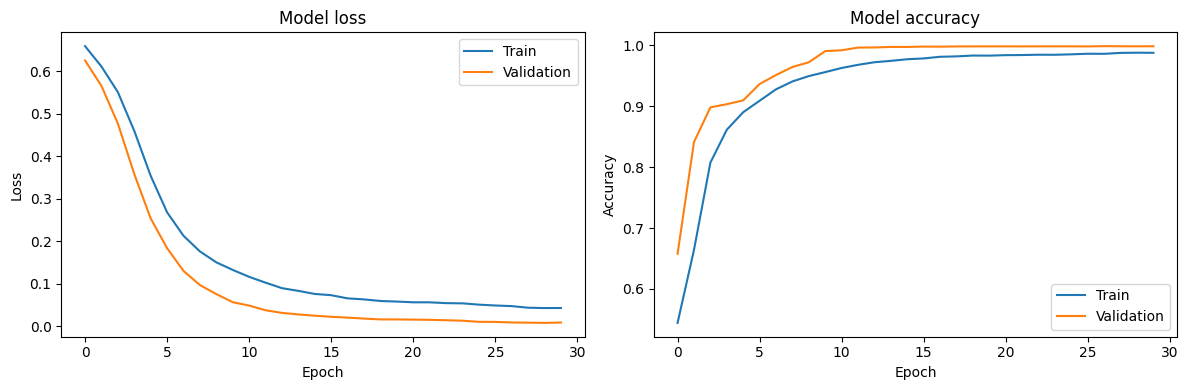

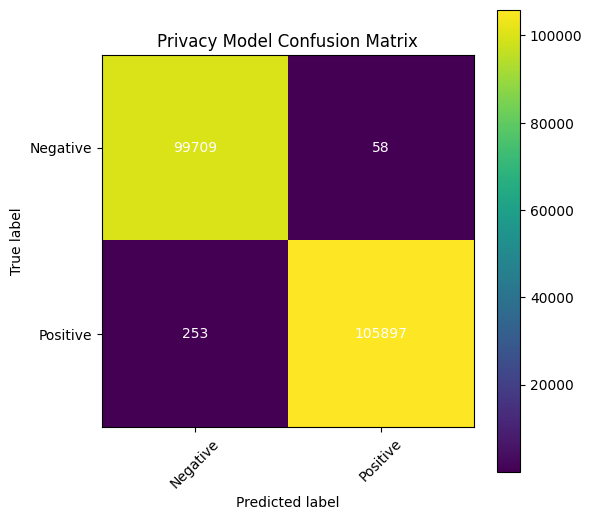

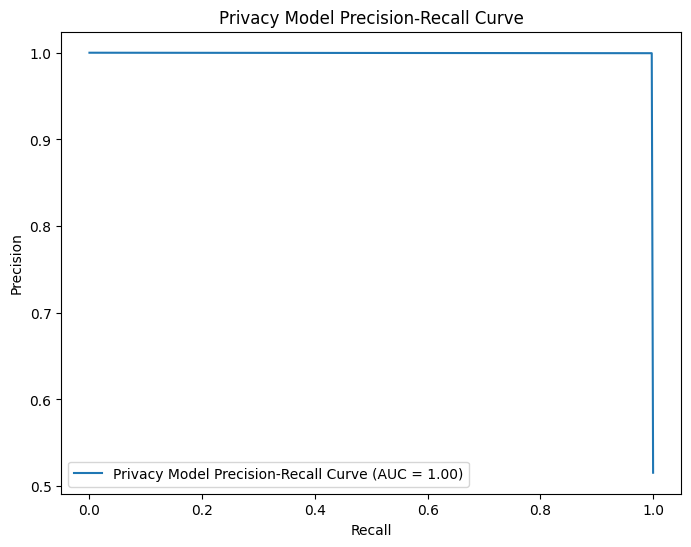

In [56]:
# Plot loss curves
plot_loss(model_history_privacy)

# Confusion Matrix
y_test_binary_true = y_test
y_test_binary_pred = y_test_pred_binary_ga_privacy
conf_matrix = confusion_matrix(y_test_binary_true, y_test_binary_pred)

plt.figure(figsize=(6, 6))
plt.imshow(conf_matrix, interpolation='nearest')
plt.title('Privacy Model Confusion Matrix')
plt.colorbar()
classes = ['Negative', 'Positive']
tick_marks = [0, 1]
plt.xticks(tick_marks, classes, rotation=45)
plt.yticks(tick_marks, classes)

for i in range(len(classes)):
    for j in range(len(classes)):
        plt.text(j, i, str(conf_matrix[i, j]), ha='center', va='center', color='w')

plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.show()

# Precision-Recall Curve
precision, recall, thresholds = precision_recall_curve(y_test_binary_true, y_test_pred_binary_ga_privacy)
area_under_curve = auc(recall, precision)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'Privacy Model Precision-Recall Curve (AUC = {area_under_curve:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Privacy Model Precision-Recall Curve')
plt.legend(loc='lower left')
plt.show()

In [57]:
# Extract trainable variables from the model
trainable_variables = mlp_model_privacy.trainable_variables

# Compute privacy budget
privacy_report = compute_dp_sgd_privacy.compute_dp_sgd_privacy_lib.compute_dp_sgd_privacy_statement(
    number_of_examples=len(X_train_scaled),
    batch_size=128,
    noise_multiplier=1.3,
    num_epochs=30,
    delta=1e-5
)

In [58]:
print(privacy_report)

DP-SGD performed over 1544371 examples with 128 examples per iteration, noise
multiplier 1.3 for 30 epochs with microbatching, and no bound on number of
examples per user.

This privacy guarantee protects the release of all model checkpoints in addition
to the final model.

Example-level DP with add-or-remove-one adjacency at delta = 1e-05 computed with
RDP accounting:
    Epsilon with each example occurring once per epoch:        74.229
    Epsilon assuming Poisson sampling (*):                      1.495

No user-level privacy guarantee is possible without a bound on the number of
examples per user.

(*) Poisson sampling is not usually done in training pipelines, but assuming
that the data was randomly shuffled, it is believed that the actual epsilon
should be closer to this value than the conservative assumption of an arbitrary
data order.

